# Machine Learning beadandó feladata
## Dataracing 2022: exportforgalom előrejelzés
Király Márk (AX83OL)

### Importáljuk a szükséges modulokat.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from optuna.samplers import TPESampler

### Töltsük be az adatokat a MEGTEKINTÉSHEZ és a korreláció mtárixhoz

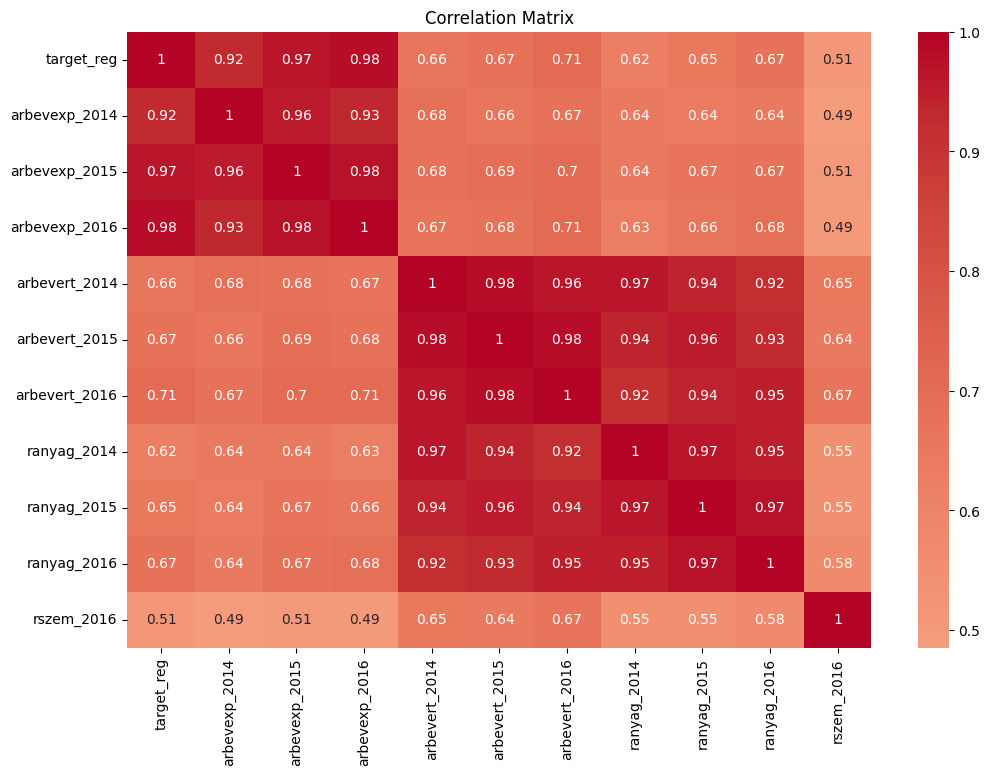

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Adatok betöltése
df = pd.read_csv("https://raw.githubusercontent.com/karsarobert/Machine_Learning_2024/main/train.csv")

# Célváltozó és prediktorok kiválasztása
y = df['target_reg']
corr_col = ['target_reg', 'arbevexp_2014', 'arbevexp_2015', 'arbevexp_2016', 'arbevert_2014', 'arbevert_2015', 'arbevert_2016', 'ranyag_2014', 'ranyag_2015', 'ranyag_2016', 'rszem_2016']
X = df[corr_col]

# Korrelációs mátrix számítása
corr_matrix = X.corr()

# Korrelációs mátrix megjelenítése
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### Töltsük be az adatokat a MODELLKÉSZÍTÉSHEZ és az ÚJ korreláció mtárixhoz
Itt generáltattam 5db új oszlopot ennek az 5-10 db magas (target_reg-hez nézve) korrelációjú oszlop értékeinek mediánjaival, ez az eljárás NEM sztochaszikus, tehát bármikor pont ugyanezzel a végeredménnyel megismételhető. => az eredeti adathalmaz egyértelműen átalakítható erre

DE! Megemlítendő, hogy sztochasztikus eljárással ennél is jobb MAE-t kapnánk!

#### Adatbetöltés CSV-ből
#### Célváltozó beállítása, eredeti és új (statisztikai szintetikus) prediktorok kiválasztása
#### Adatfelosztás tanító -és teszt halmazokra (skálázás később lesz!)
#### Korrelációmátrix rajzolása

/tmp/ipykernel_73585/676601618.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  height_corr_cols = df.corr()['target_reg'][df.corr()['target_reg'].abs() > 0.7].index.tolist()
/tmp/ipykernel_73585/676601618.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'Synthetic_{i+1}'] = feature
/tmp/ipykernel_73585/676601618.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Shape of X_train: (19908, 15)
Shape of X_test: (13272, 15)


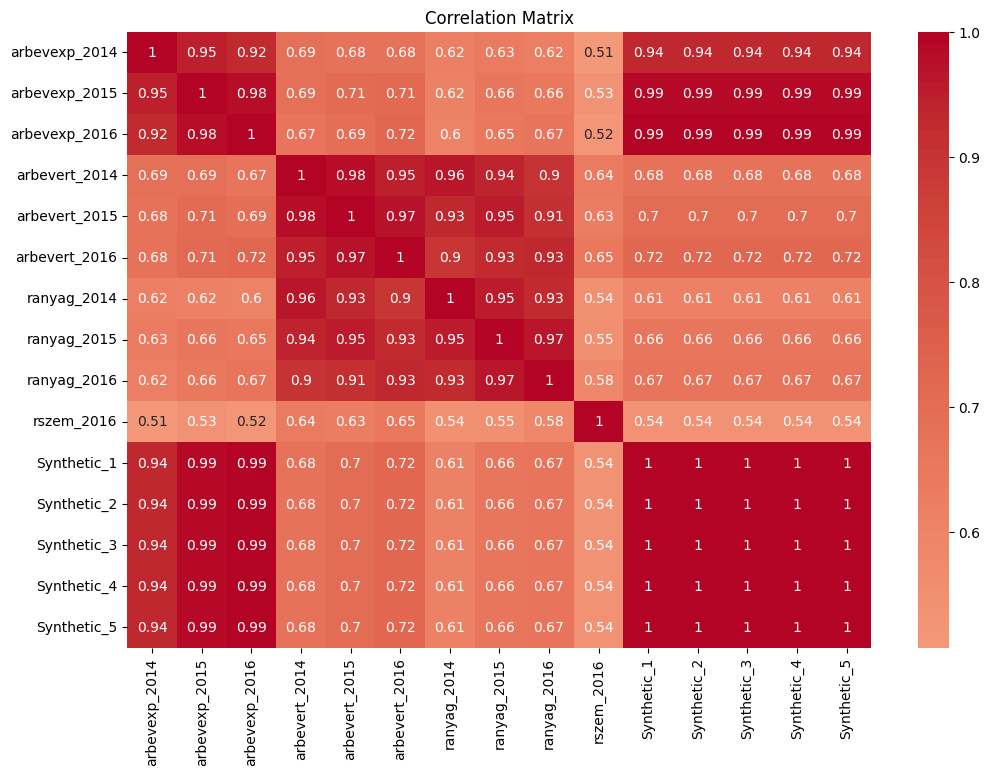

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Adatok betöltése
df = pd.read_csv("https://raw.githubusercontent.com/karsarobert/Machine_Learning_2024/main/train.csv")

# Célváltozó és prediktorok kiválasztása
y = df['target_reg']
corr_col = ['arbevexp_2014', 'arbevexp_2015', 'arbevexp_2016', 'arbevert_2014', 'arbevert_2015', 'arbevert_2016', 'ranyag_2014', 'ranyag_2015', 'ranyag_2016', 'rszem_2016']

# Oszlopok kiválasztása, amelyek korrelációja nagyobb, mint 0,7
height_corr_cols = df.corr()['target_reg'][df.corr()['target_reg'].abs() > 0.7].index.tolist()

# Szintetikus oszlopok létrehozása másodlagos statisztikákkal (SZTOCHASZTIKUS: jobb eredmény)
#num_synthetic_features = 5  # Módosítottuk 5-re
#synthetic_features = []
# for i in range(num_synthetic_features):
#     idx = np.random.choice(len(low_corr_cols), size=3, replace=False)  # Válasszuk ki véletlenszerűen az alacsony korrelációjú oszlopokat
#     selected_cols = [low_corr_cols[j] for j in idx]
#     synthetic_feature = df[selected_cols].median(axis=1)  # Generáljuk a másodlagos statisztikákat
#     synthetic_features.append(synthetic_feature)

# Szintetikus oszlopok létrehozása másodlagos statisztikákkal (NEM SZTOCHASZTIKUS: reprodukálható)
num_synthetic_features = 5  # Módosítottuk 5-re
synthetic_features = []
for i in range(num_synthetic_features):
    selected_cols = height_corr_cols
    synthetic_feature = df[selected_cols].median(axis=1)  # Generáljuk az oszlopok mediánját
    synthetic_features.append(synthetic_feature)

# Az X_train-hez hozzáadjuk az újonnan létrehozott szintetikus oszlopokat
X = df[corr_col]
for i, feature in enumerate(synthetic_features):  
    X[f'Synthetic_{i+1}'] = feature  

# Adatok felosztása tanító és teszt halmazokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Ellenőrzés
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Korrelációs mátrix számítása az X_train-re
corr_matrix = X_train.corr()

# Korrelációs mátrix megjelenítése
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### Végezzünk adatbővítést! (Csak szintetikus adatok hozzáadásával)
#### 2-szer annyi szintetikus adatot gyártunk lineáris kombinációval, mint az eredeti tanítóhalmaz
#### Ok: a tanítóhalmaz túl kicsi a 0,6-0,4-es felosztás miatt...
##### Megj.: A skálázást (standardizálás) is itt végezzük el!

In [5]:
# Zaj hozzáadása
#noise_factor = 0.1
#X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)
#X_test_noisy = X_test + noise_factor * np.random.randn(*X_test.shape)

# Szintetikus adatok generálása lineáris kombinációval
def generate_synthetic_data(X, y, num_samples):
    synthetic_X = []
    synthetic_y = []
    num_features = X.shape[1]
    
    for _ in range(num_samples):
        idx1, idx2 = np.random.choice(len(X), size=2, replace=False)
        alpha = np.random.rand()
        
        new_sample_X = alpha * X.iloc[idx1] + (1 - alpha) * X.iloc[idx2]
        new_sample_y = alpha * y.iloc[idx1] + (1 - alpha) * y.iloc[idx2]
        
        synthetic_X.append(new_sample_X)
        synthetic_y.append(new_sample_y)
    
    return pd.DataFrame(synthetic_X, columns=X.columns), pd.Series(synthetic_y)

# Generáljunk szintetikus adatokat a tanító halmazhoz
num_synthetic_samples = len(X_train) * 2  # 2-szer több szintetikus minta, mint az eredeti tanító halmaz
X_synthetic, y_synthetic = generate_synthetic_data(X_train, y_train, num_synthetic_samples)

# Kombináljuk az eredeti és szintetikus adatokat
X_train_augmented = pd.concat([X_train, X_synthetic]) #javítás
y_train_augmented = pd.concat([y_train, y_synthetic])

# StandardScaler létrehozása és illesztése a tanító adatokra
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_augmented)
X_test_scaled = scaler.transform(X_test) #javítás

# Az újonnan zajosított és skálázott adatok ellenőrzése
print("X_train_scaled (augmented):", X_train_scaled[:5])
print("X_test_scaled:", X_test_scaled[:5])

X_train_scaled (augmented): [[-0.11124597 -0.10772796 -0.10782041 -0.00297708 -0.04051202 -0.19304902
   0.03683242 -0.03204071 -0.17668729 -0.17160321 -0.11054015 -0.11054015
  -0.11054015 -0.11054015 -0.11054015]
 [-0.11124597 -0.10772796 -0.10782041 -0.22769017 -0.23290384 -0.22774047
  -0.21667225 -0.22343716 -0.21830642 -0.18054335 -0.11054015 -0.11054015
  -0.11054015 -0.11054015 -0.11054015]
 [-0.11124597 -0.10772796 -0.10782041 -0.09881913 -0.11506108 -0.11568977
  -0.06171847 -0.07111586 -0.05461386 -0.16614177 -0.11054015 -0.11054015
  -0.11054015 -0.11054015 -0.11054015]
 [-0.11124597 -0.10772796 -0.10782041 -0.24056369 -0.24044732 -0.23427076
  -0.22593913 -0.23424851 -0.22745957 -0.18510621 -0.11054015 -0.11054015
  -0.11054015 -0.11054015 -0.11054015]
 [-0.11124597 -0.10772796 -0.10782041 -0.23762745 -0.23918668 -0.23425918
  -0.22654272 -0.23351178 -0.22543936 -0.17596584 -0.11054015 -0.11054015
  -0.11054015 -0.11054015 -0.11054015]]
X_test_scaled: [[-1.11245968e-01 -1.

## Építsünk modelt!
### Futtatáskor figyeljünk rá, hogy a MAE-t és a további jellemzőket az eredeti halmazon mérjük (y_test, y_pred).
### A modell a következőket használja: 
#### Random Forest regresszió, 
#### Optuna hiperparaméterkereső keretrendszer, ezen belűl a TPESampler fa alapú keresőalgoritmus
### A bővített predikátorváltozós halmazon edzettem és validáltam is a modellt.

In [6]:
# Célfüggvény definiálása
def objective(trial):
    # Hiperparaméterek meghatározása
    n_estimators = trial.suggest_int('n_estimators', 10, 200) #(10,200)
    max_depth = trial.suggest_int('max_depth', 1, 20) #(1,20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10) #(2,10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4) #(1,4)
    
    # Random Forest modell létrehozása a megadott hiperparaméterekkel
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    # Modell illesztése
    model.fit(X_train_scaled, y_train_augmented)
    
    # Előrejelzések készítése
    y_pred = model.predict(X_test_scaled)
    
    # MAE számolása
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# "Tanulmány" létrehozása és futtatása
try:
    study = optuna.create_study(direction='minimize', sampler=TPESampler())
    study.optimize(objective, n_trials=10)  # , timeout=900) Tehát maximum 0,25 óráig fut - kikommentelve
except optuna.exceptions.TrialPruned as e:
    print("Optimization stopped:", e)

# Legjobb paraméterek kiíratása
print("Best hyperparameters: ", study.best_params)

# Legjobb modell létrehozása a legjobb paraméterekkel
best_params = study.best_params
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,  # Marad változatlan!
    n_jobs=-1  # Párhuzamosítás miatt kell (igaz csak CPU-n párhuzamosít...)
)

# Legjobb modell illesztése a teljes edzési adatokra
best_model.fit(X_train_scaled, y_train_augmented)

# Előrejelzések készítése a teszthalmazon
y_pred = best_model.predict(X_test_scaled)

# Hibametrikák kiértékelése és kiíratása
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Final Model Performance on Test Set:')
print('Mean Squared Error:', mse)
print('R-squared Score:', r2)
print('Mean Absolute Error:', mae)

[I 2024-05-28 22:21:59,443] A new study created in memory with name: no-name-40a6bf3f-e6aa-4b15-a0b2-d53905272829
[I 2024-05-28 22:22:00,052] Trial 0 finished with value: 272952.9447887472 and parameters: {'n_estimators': 69, 'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 272952.9447887472.
[I 2024-05-28 22:22:03,187] Trial 1 finished with value: 156042.69249337175 and parameters: {'n_estimators': 181, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 156042.69249337175.
[I 2024-05-28 22:22:13,448] Trial 2 finished with value: 39817.959403566885 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 39817.959403566885.
[I 2024-05-28 22:22:19,202] Trial 3 finished with value: 40223.63456409778 and parameters: {'n_estimators': 70, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 39817

Best hyperparameters:  {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}
Final Model Performance on Test Set:
Mean Squared Error: 163610073365.56696
R-squared Score: 0.9733286432853993
Mean Absolute Error: 39817.959403566885


#### A modell prediktív ereje itt látható: (MAE 39817) 

In [7]:
# Előrejelzések készítése a teszthalmazon
y_pred = best_model.predict(X_test_scaled)

# Hibametrikák kiértékelése és kiíratása
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Final Model Performance on Test Set:')
print('Mean Squared Error:', mse)
print('R-squared Score:', r2)
print('Mean Absolute Error:', mae)

Final Model Performance on Test Set:
Mean Squared Error: 163610073365.56696
R-squared Score: 0.9733286432853993
Mean Absolute Error: 39817.959403566885


### Megnézem az X_test-et (ezen edzettem és validáltam a modellt), szemmel láthatóak a másodlagos statisztikák.
##### MEGJ.: A modellnek 10 bemenetje vagy a 15 helyett.

In [8]:
X_test

,arbevexp_2014,arbevexp_2015,arbevexp_2016,arbevert_2014,arbevert_2015,arbevert_2016,ranyag_2014,ranyag_2015,ranyag_2016,rszem_2016,Synthetic_1,Synthetic_2,Synthetic_3,Synthetic_4,Synthetic_5
28944,0.0,0.0,0.0,44596.0,38577.0,34638.0,33402.0,26565.0,23886.0,7114.0,0.0,0.0,0.0,0.0,0.0
24153,0.0,0.0,0.0,4934187.0,5509561.0,5277569.0,2911680.0,3395972.0,3164706.0,1733037.0,0.0,0.0,0.0,0.0,0.0
1402,0.0,0.0,0.0,188571.0,182364.0,147050.0,57115.0,58262.0,66633.0,46017.0,0.0,0.0,0.0,0.0,0.0
4219,213714.0,195185.0,185910.0,265742.0,219657.0,245325.0,150144.0,127345.0,143715.0,52085.0,213714.0,213714.0,213714.0,213714.0,213714.0
6462,0.0,0.0,0.0,56121.0,58511.0,49963.0,47397.0,48461.0,41450.0,5277.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10862,0.0,0.0,0.0,3584.0,3711.0,3902.0,2584.0,2388.0,2439.0,960.0,0.0,0.0,0.0,0.0,0.0
3405,0.0,0.0,0.0,8476.0,11689.0,13825.0,5232.0,8099.0,9016.0,3195.0,0.0,0.0,0.0,0.0,0.0
16308,0.0,0.0,0.0,3614.0,7407.0,5274.0,5058.0,7486.0,6569.0,9237.0,0.0,0.0,0.0,0.0,0.0
29386,79173661.0,88318376.0,76601608.0,91484685.0,100812707.0,88246124.0,88059911.0,97212331.0,83695427.0,1131996.0,87760444.0,87760444.0,87760444.0,87760444.0,87760444.0


### Leellenőriztem az elkészült model "features_importances"-jét, amivel kiderült hogy a modell ezeken a másodlagos statisztikai eredményeket tanult legfőképp és ezért lett ennyire pontos.

In [12]:
# Feature importances kiíratása
print("Feature importances:")
for feature, importance in zip(X.columns, best_model.feature_importances_):
    print(f"{feature}: {importance}")

Feature importances:
arbevexp_2014: 0.005176316845959501
arbevexp_2015: 0.011586736122287205
arbevexp_2016: 0.05074736533652478
arbevert_2014: 0.001874768316567068
arbevert_2015: 0.001408032126157787
arbevert_2016: 0.0014989310796240574
ranyag_2014: 0.0010088183036992043
ranyag_2015: 0.0009525587559031052
ranyag_2016: 0.002187396346095733
rszem_2016: 0.003311096147184016
Synthetic_1: 0.175273811862209
Synthetic_2: 0.12955812387328716
Synthetic_3: 0.20464018271156775
Synthetic_4: 0.23079108854169036
Synthetic_5: 0.17998477363124332


### Most "szemmel ellenőriztem" a target_reg és predicted_target_reg oszlopokat is: reálisnak tűnhet a kijött MAE.
#### A MAE-t így számoljuk (n: minta darabszáma, y_i valós értékek, ykalap_i prediktált értékek):
$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$

In [10]:
# Eredeti DataFrame létrehozása
result_df = pd.DataFrame({'target_reg': y_test, 'predicted_target_reg': y_pred})

# Kiíratás
print(result_df[:25])

       target_reg  predicted_target_reg
28944         0.0             70.097757
24153         0.0         217532.428593
1402          0.0            235.903871
4219     216582.0         235141.438329
6462          0.0             77.284965
26106        12.0            487.280458
17588      2588.0           3698.617172
30112         0.0             55.924395
14488         0.0             29.816089
26294         0.0            384.248792
15561         0.0            245.818723
13924         0.0            859.750834
21409         0.0             61.074682
14085         0.0             77.304599
15548         0.0             81.052624
25290         0.0            672.287402
18661         0.0           5163.192479
6867          0.0           2347.970531
4061          0.0             64.584779
13553    124699.0         141547.182265
27847         0.0             74.618345
11505         0.0            232.992530
2847          0.0             15.840938
30565         0.0            164.644936


# A kérdés a következő: lehet-e a prediktorok számát egyértelműen származtatható/kiszámítható értékekkel bővíteni?
## Sőőt... lehet-e sztochasztikus alapon származtatott érkékekkel?